# **Introduction**

This notebook is for implementing the SARSA(λ) algorithm, which is an on-policy temporal difference method that utilizes the concept of averaging over all $n$-step returns. Every $n$-step return from $0~to~\infty$ is considered, and the returns are incrementally weighted by a factor of $\lambda$ each time-step, normalized by $(1-\lambda)$.

Similar to other implementations, this will be done using the Frozen Lake environment offered through Gymnasium, which is an open source Python library for developing and comparing reinforcement learning algorithms, through the use of a standardized API. 

# **Import Packages**

This section imports the necessary packages.

In [75]:
# Import these packages:
import gymnasium as gym 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# **Environment Setup**

This section sets up the environment and defines the relevant functions needed for this implementation.

In [76]:
# SARSA(λ)-Agent Class:
class SARSA_L_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self, env: gym.Env, gamma: float, alpha: float, lamb: float, beta: float, es: bool, rs: bool):
        """
        this is the constructor for the agent. this agent is a TD-based agent, implementing SARSA(λ), meaning that the policy
        is evaluated and improved every time-step by examining all n-step returns

        env:    a gymnasium environment
        gamma:  a float value indicating the discount factor
        alpha:  a float value indicating the learning rate
        lamb: a float value indicating the trace decay rate, λ
        beta:   a float value indicating the decay rate of ε
        es:     a boolean value indicating whether to use exploring starts or not
        rs:     a boolean value indicating whether to use reward shaping or not
        if true:
        goal_value: +10.0
        hole_value: -1.0
        else:
        goal_value: +1.0
        hole_value: 0.0 (sparsely defined)
        Q:      the estimate of the action-value function q, initialized as zeroes over all states and actions
        E:      the eligibility trace, initialized as zeroes over all states and actions

        """

        # object parameters:
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.lamb = lamb
        self.beta = beta
        self.es = es
        self.rs = rs

        # set the reward shaping:
        if self.rs:
            self.goal_value = 10.0
            self.hole_value = -1.0
        else:
            self.goal_value = 1.0
            self.hole_value = 0.0

        # get the number of states, number of actions:
        self.nS, self.nA = env.observation_space.n, env.action_space.n

        # get the terminal spaces of the current map:
        desc = env.unwrapped.desc.astype("U1")
        chars = desc.flatten()
        self.terminal_states = [i for i, c in enumerate(chars) if c in ("H", "G")]

        # tabular Q values:
        self.Q = np.zeros((self.nS, self.nA))

        # return to the user the metrics about the environment:
        print(f"Action Space is: {env.action_space}")
        print(f"Observation Space is: {env.observation_space}\n")

    ####################### TRAINING #######################
    # function to perform ε-greedy probability assignment:
    def get_action_probs(self, Q):
        """ 
        this function does the ε-greedy probability assignment for the actions available in a given state

        Q:          a np.ndarray corresponding to the action-values of the actions available in a given state
        returns:    probability of selecting each action

        """
        # get the number of available actions:
        m = len(Q)

        # assign each action a base probability of ε/m:
        p = np.ones(m)*(self.epsilon/m)

        # find the index of the best Q value:
        best = np.argmax(Q)

        # give that one more probability by an amount equal to (1 - ε):
        p[best] += 1.0 - self.epsilon

        # this way the "best" action has a probability of ε/m + (1-ε), meaning it will be chosen more often
        # whereas the others have a probability of ε/m, so there is a probability that exploratory actions will be selected

        # return the probability of selecting each action:
        return p

    # ε-greedy policy function:
    def policy(self, state):
        """ 
        this is the ε-greedy policy itself, where it chooses an action based on the ε-greedy probabilities of each action

        state:      an int representing the current state
        returns:    a randomly selected action

        """
        probs = self.get_action_probs(self.Q[state])    # for a given state, or row in Q
        return np.random.choice(len(probs), p = probs)  # pick an action from the probabilities of each action

    # GPI function using backward-view SARSA(λ) update rule and ε-greedy policy:
    def GPI(self, num_episodes):
        """ 
        this function performs the generalized policy iteration using backward-view SARSA(λ) as the evaluation modality and
        ε-greedy policy improvement to improve the policy

        num_episodes:   number of desired episodes to train the agent on
        returns:        the updated Q values

        """
        for k in tqdm(range(num_episodes), colour = "#33FF00", ncols = 100):
            # first must decay ε:
            # self.epsilon = 0.25
            self.epsilon = np.exp(-self.beta*k)

            # reset the eligibility trace:
            self.E = np.zeros((self.nS, self.nA))

            # if exploring starts:
            if self.es:
                non_terminals = [s for s in range(self.env.observation_space.n) if s not in self.terminal_states]
                starting_state = np.random.choice(non_terminals)

                # force env into starting state:
                _, _ = self.env.reset()
                self.env.unwrapped.s = starting_state
                obs = starting_state
            else:
                obs, _ = self.env.reset()

            # ε-greedily select an action:
            action = self.policy(obs)

            # flag for finishing:
            done = False

            # while False:
            while not done:
                next_obs, r, term, trunc, _ = self.env.step(action)     # take action A, observe R, S'
                next_action = self.policy(next_obs)                     # choose A' from S' using ε-greedy policy Q

                # if reward shaping:
                if self.rs:
                    if term and r == 0:
                        r = self.hole_value     # fell in a hole
                    elif term and r == 1:
                        r = self.goal_value     # reached goal
                    
                # compute delta:
                delta = r + self.gamma*self.Q[next_obs, next_action] - self.Q[obs, action]

                # advance trace:
                self.E[obs, action] += 1

                for s in range(self.nS):
                    for a in range(self.nA):
                        self.Q[s, a] += self.alpha*delta*self.E[s, a]
                        self.E[s, a] = self.gamma*self.lamb*self.E[s, a]
                
                # advance state and action indicies:
                obs, action = next_obs, next_action

                # check for completion:
                done = term or trunc
        
        return self.Q

    ####################### EVALUATION #######################
    # average return per episode:
    def average_return(self, agent, num_episodes):
        """ 
        this function computes the average return per episode for a given amount of episodes

        agent:          the agent that has been trained
        num_episode:    number of episodes to play out
        returns:        the average return per episode

        """
        # initialize the total return received over the evaluation:
        total_return = 0

        # for every episode:
        for _ in tqdm(range(num_episodes), colour = "#33FF00", ncols = 100):
            obs, _ = agent.env.reset()      # must reset before an episode
            done = False                    # flag is set to False initially
            episode_return = 0              # reset return for the episode

            # while False:
            while not done:
                a = np.argmax(agent.Q[obs])                     # pick best action from policy
                obs, r, term, trunc, _ = agent.env.step(a)      # step that action
                episode_return += r     # increment the episode return by that return
                done = term or trunc    # set to True if term or trunc

                total_return += episode_return  # increment total return by episode return

        return round(total_return / num_episodes, 3)      # average return accross all episodes

    # success rate:
    def success_rate(self, agent, num_episodes):
        """ 
        this function computes the success rate for a given amount of episodes

        agent:          the agent that has been trained
        num_episode:    number of episodes to play out
        returns:        the success rate for that stretch of episodes

        """
        # initialize number of successes:
        success = 0

        # for every episode:
        for _ in tqdm(range(num_episodes), colour = "#33FF00", ncols = 100):
            obs, _ = agent.env.reset()      # must reset before an episode
            done = False                    # flag is set to False initially

            # while False:
            while not done:
                a = np.argmax(agent.Q[obs])                     # pick best action from policy
                obs, r, term, trunc, _ = agent.env.step(a)      # step that action
                done = term or trunc    # set to True if term or trunc

                # if at the goal pose
                if r == self.goal_value:
                    success += 1    # increment the success counter

        return round((success / num_episodes) * 100, 3)   # return success rate

    # average episode length:
    def average_length(self, agent, num_episodes):
        """ 
        this function computes the average episode length for a given amount of episodes

        agent:          the agent that has been trained
        num_episodes:   number of episodes to play out
        returns:        the average episode length for that stretch of episodes

        """
        # initialize the total number of steps over the evaluation:
        total_steps = 0

        # for every episode:
        for _ in tqdm(range(num_episodes), colour = "#33FF00", ncols = 100):
            obs, _ = agent.env.reset()      # must reset before an episode
            done = False                    # flag is set to False initially
            episode_steps = 0               # reset steps for the episode

            # while False:
            while not done:
                a = np.argmax(agent.Q[obs])                     # pick best action from policy
                obs, _, term, trunc, _ = agent.env.step(a)      # step that action
                episode_steps += 1                              # increment episode steps

                done = term or trunc    # set to True if term or trunc

                total_steps += episode_steps    # increment total steps by steps taken in episode

        # return the average steps per episode to the user:
        return round(total_steps / num_episodes, 3)


# **Using the Environment**

This section utilizes the above object-oriented approach to create an environment and train an agent. 

In [77]:
# create training environment:
env = gym.make("FrozenLake-v1", is_slippery = False, render_mode = "rgb_array")

# instantiate the agent:
agent = SARSA_L_Agent(env = env, 
                      gamma = 0.99, 
                      alpha = 0.5, 
                      lamb = 0.0, 
                      beta = 1e-5, 
                      es = False, 
                      rs = False)
num_episodes = 500000

# learn value function using SARSA(λ):
q = agent.GPI(num_episodes = num_episodes).round(3)

Action Space is: Discrete(4)
Observation Space is: Discrete(16)



100%|█████████████████████████████████████████████████████| 500000/500000 [03:42<00:00, 2248.43it/s]


# **Benchmark the Learned Policy**
This section uses the evaluation functions defined within the class to check how the learned policy fares over a set of episodes.

In [78]:
# set num_episodes to desired testing length:
num_episodes = 10000

# evaluate and print to the user:
avg_return = agent.average_return(agent, num_episodes)
print(f"The average return per episode is: {avg_return}\n")

avg_length = agent.average_length(agent, num_episodes)
print(f"The average episode length is: {avg_length} steps\n")

success_rate = agent.success_rate(agent, num_episodes)
print(f"The success rate is: {success_rate}%")

100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33750.02it/s]


The average return per episode is: 1.0



100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33417.90it/s]


The average episode length is: 21.0 steps



100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 33802.03it/s]

The success rate is: 100.0%


# **Visualize the Learned Policy**

This section visualizes the final policy that was learned and overlays a heatmap of the best action-value from the function $Q(s,a)$.

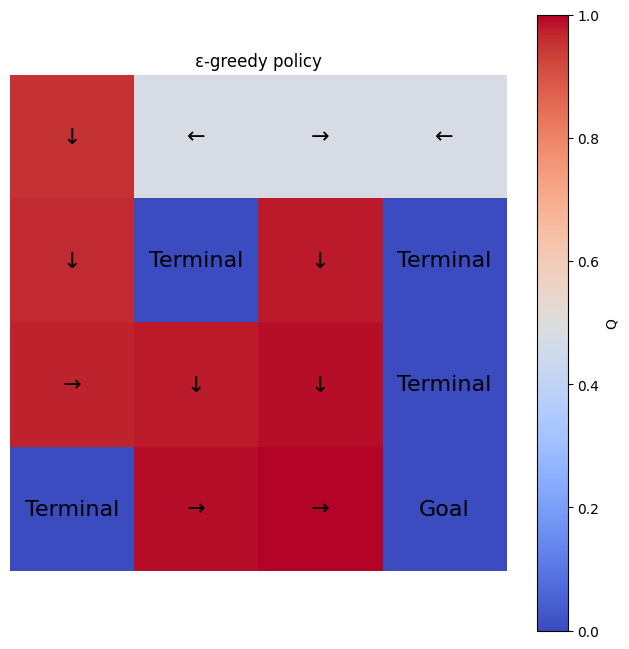

In [79]:
# define mapping of actions to directions:
action_map = {0: '←', 1: '↓', 2: '→', 3: '↑', 4: 'Terminal', 5 : 'Goal'}
size = int(np.sqrt(agent.env.observation_space.n))
grid = np.zeros(agent.env.observation_space.n, dtype = object)

# for every state:
for s in range(agent.env.observation_space.n):
    if s in agent.terminal_states:
        if s == 15:
            action = 5
        else:
            action = 4
    else:
        action = np.argmax(q[s, :])

    grid[s] = action_map[action]

# reshape to look like map:
grid = grid.reshape(size, size)

# plot stuff:
fig, ax = plt.subplots(figsize = (2*size, 2*size))

# heatmap stuff:
heatmap_value = np.max(q, axis = 1).reshape((4,4))
heatmap = ax.imshow(heatmap_value, cmap = 'coolwarm', interpolation = 'nearest')

# overlay text:
for i in range(size):
    for j in range(size):
        text = grid[i, j]
        ax.text(j, i, text, ha = 'center', va = 'center', color = 'black', fontsize = 16)

# formatting:
fig.colorbar(heatmap, ax = ax, label = 'Q')
ax.set_title('ε-greedy policy')
ax.axis('off')

plt.show()